# **MODELO PARA ROCK, PAPER, SCISSORS**

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

In [7]:
import PIL
import torch
import torchvision
import matplotlib
import cv2 as opencv
import scipy
import sklearn

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("Pillow:", PIL.__version__)
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
#print("tqdm:", tqdm.__version__)
print("opencv", opencv.__version__)
print("scipy", scipy.__version__)
!python --version


numpy: 2.1.3
pandas: 2.2.3
Pillow: 11.1.0
torch: 2.9.1+cpu
torchvision: 0.24.1+cpu
matplotlib: 3.10.0
seaborn: 0.13.2
scikit-learn: 1.6.1
opencv 4.12.0
scipy 1.15.3
Python 3.13.5


In [8]:
# ============================================
# CONFIGURACIÓN
# ============================================
CONFIG = {
    # Paths
    'dataset_dir': 'dataset',  # Carpeta raíz del dataset
    
    # Clases (sin 'none' si no lo quieres)
    'classes': ['paper', 'rock', 'scissors'],  # Eliminamos 'none'
    
    # Hiperparámetros
    'batch_size': 8,
    'epochs': 30,
    'learning_rate': 5e-5,
    'weight_decay': 1e-4,
    
    # Secuencias temporales
    'emg_seq_len': 400,
    'imu_seq_len': 100,
    
    # Training
    'num_workers': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Modo
    'use_myo': True,  # False = solo RGB+Landmarks

    'sensor_noise': 0.01,
    'sensor_p': 0.5,
    'mixup_alpha': 0.4,
}


In [9]:
# ============================================
# FUNCIONES DE PREPROCESAMIENTO
# ============================================
def normalize_emg(emg_data):
    """Normaliza EMG a [-1, 1]"""
    return emg_data / 128.0

def normalize_imu(orientation, acceleration, gyroscope):
    """Normaliza IMU"""
    acc_norm = acceleration / 10.0
    gyro_norm = gyroscope / 100.0
    return np.concatenate([orientation, acc_norm, gyro_norm], axis=1)

def pad_or_truncate_sequence(sequence, target_length):
    """Ajusta longitud de secuencia temporal"""
    current_length = len(sequence)
    
    if current_length == 0:
        # Si no hay datos, retornar zeros
        return np.zeros((target_length, sequence.shape[1] if len(sequence.shape) > 1 else 1), dtype=np.float32)
    
    if current_length < target_length:
        # Pad con últimos valores
        padding = np.repeat(sequence[-1:], target_length - current_length, axis=0)
        return np.vstack([sequence, padding])
    else:
        # Truncate
        return sequence[:target_length]

def load_landmarks(landmarks_path):
    """
    Carga landmarks y aplica normalización relativa.
    Retorna: (21, 3) array con coordenadas centradas en la muñeca.
    """
    df = pd.read_csv(landmarks_path)
    # Extraer coordenadas x, y, z
    landmarks = df[['x', 'y', 'z']].values.astype(np.float32)
    
    # NORMALIZACIÓN RELATIVA:
    # Restamos la posición de la muñeca (índice 0) a todos los puntos.
    # Así, la muñeca siempre estará en (0, 0, 0).
    wrist = landmarks[0]
    landmarks_relative = landmarks - wrist
    
    return landmarks_relative  # (21, 3) centrados

def load_emg(emg_path):
    """
    Carga EMG desde CSV
    Formato: index, timestamp, ch0, ch1, ..., ch7
    Retorna: (seq_len, 8) array normalizado
    """
    df = pd.read_csv(emg_path)
    # Extraer canales (columnas ch0-ch7)
    emg_cols = [f'ch{i}' for i in range(8)]
    emg_data = df[emg_cols].values.astype(np.float32)
    return normalize_emg(emg_data)  # (seq_len, 8)

def load_imu(imu_path):
    """
    Carga IMU desde CSV
    Formato: index, timestamp, ori_x, ori_y, ori_z, ori_w, acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z
    Retorna: (seq_len, 10) array normalizado
    """
    df = pd.read_csv(imu_path)
    
    # Extraer columnas
    orientation = df[['ori_x', 'ori_y', 'ori_z', 'ori_w']].values
    acceleration = df[['acc_x', 'acc_y', 'acc_z']].values
    gyroscope = df[['gyr_x', 'gyr_y', 'gyr_z']].values
    
    return normalize_imu(orientation, acceleration, gyroscope)  # (seq_len, 10)


In [10]:
# ============================================
# INDEXAR DATASET
# ============================================
def index_synchronized_dataset(base_dir):
    """
    Indexa el dataset sincronizado creado por dataset_creator_myo.py
    
    Returns:
        List of dicts con rutas a todos los archivos de cada sample
    """
    samples = []
    
    images_dir = os.path.join(base_dir, 'images')
    landmarks_dir = os.path.join(base_dir, 'landmarks')
    emg_dir = os.path.join(base_dir, 'emg')
    imu_dir = os.path.join(base_dir, 'imu')
    
    # Iterar por cada clase
    for gesture in CONFIG['classes']:
        gesture_img_dir = os.path.join(images_dir, gesture)
        
        if not os.path.exists(gesture_img_dir):
            print(f"[WARNING] No existe carpeta: {gesture_img_dir}")
            continue
        
        # Listar todas las imágenes
        image_files = sorted([f for f in os.listdir(gesture_img_dir) if f.endswith('.jpg')])
        
        for img_file in image_files:
            # Extraer base name: rock_0001.jpg -> rock_0001
            base_name = img_file.replace('.jpg', '')
            
            # Construir rutas
            img_path = os.path.join(gesture_img_dir, img_file)
            landmarks_path = os.path.join(landmarks_dir, f"{base_name}_landmarks.csv")
            emg_path = os.path.join(emg_dir, f"{base_name}_emg.csv")
            imu_path = os.path.join(imu_dir, f"{base_name}_imu.csv")
            meta_path = os.path.join(landmarks_dir, f"{base_name}_meta.json")
            
            # Verificar que todos los archivos existan
            if all(os.path.exists(p) for p in [img_path, landmarks_path, emg_path, imu_path]):
                samples.append({
                    'image_path': img_path,
                    'landmarks_path': landmarks_path,
                    'emg_path': emg_path,
                    'imu_path': imu_path,
                    'meta_path': meta_path if os.path.exists(meta_path) else None,
                    'label': gesture
                })
            else:
                print(f"[WARNING] Archivos incompletos para: {base_name}")
    
    return samples

In [11]:
# ============================================
# MYO AUGMENTATION
# ============================================

class SensorAugmentation:
    def __init__(self, noise_sigma=0.01, scale_range=(0.85, 1.15), p=0.5):
        self.noise_sigma = noise_sigma
        self.scale_range = scale_range
        self.p = p

    def __call__(self, emg, imu):
        if np.random.rand() > self.p:
            return emg, imu

        # Ruido Gaussiano
        if self.noise_sigma > 0:
            emg = emg + torch.randn_like(emg) * self.noise_sigma
            imu = imu + torch.randn_like(imu) * self.noise_sigma
        
        # Escalado (Magnitude Warping)
        scale = np.random.uniform(*self.scale_range)
        emg = emg * scale
        imu = imu * scale
        
        return emg, imu

In [16]:
# ============================================
# DATASET CLASS
# ============================================
class SynchronizedMultimodalDataset(Dataset):
    def __init__(self,
                 samples,
                 img_size=(224, 224),
                 transform=None,
                 landmark_stats=None,
                 emg_seq_len=400,
                 imu_seq_len=100,
                 use_myo=True,
                 sensor_augment=None): # <--- NUEVO: Parámetro de aumentación
        
        self.samples = samples
        self.transform = transform
        self.use_myo = use_myo
        self.emg_seq_len = emg_seq_len
        self.imu_seq_len = imu_seq_len
        self.sensor_augment = sensor_augment # <--- NUEVO
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(CONFIG['classes'])}
        
        if landmark_stats:
            self.lm_mean, self.lm_std = landmark_stats['mean'], landmark_stats['std']
        else:
            self.lm_mean, self.lm_std = self._compute_landmark_stats()
        
        self.default_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def _compute_landmark_stats(self):
        """Calcula media y std de landmarks"""
        all_landmarks = []
        sample_size = min(100, len(self.samples))
        
        for i in range(sample_size):
            lm = load_landmarks(self.samples[i]['landmarks_path'])
            all_landmarks.append(lm.flatten())
        
        all_landmarks = np.array(all_landmarks)
        mean = all_landmarks.mean(axis=0)
        std = all_landmarks.std(axis=0) + 1e-8
        
        return mean.astype(np.float32), std.astype(np.float32)
    
    def get_stats(self):
        return {'mean': self.lm_mean, 'std': self.lm_std}

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # 1. CARGAR IMAGEN
        image = Image.open(sample['image_path']).convert('RGB')
        image = self.transform(image) if self.transform else self.default_transform(image)
        
        # 2. CARGAR LANDMARKS
        landmarks = load_landmarks(sample['landmarks_path'])

        # --- NUEVA MEJORA: Landmark Jitter (Solo en entrenamiento) ---
        if self.sensor_augment: # Usamos el mismo flag que activa la aumentación de sensores
            # Añade un ruido muy pequeño (ej. 0.5% de variación)
            noise = np.random.normal(0, 0.005, landmarks.shape)
            landmarks = landmarks + noise
        # -------------------------------------------------------------
        
        landmarks_flat = landmarks.flatten()
        landmarks_flat = (landmarks_flat - self.lm_mean) / self.lm_std
        landmarks_tensor = torch.from_numpy(landmarks_flat).float()
        
        # 3. CARGAR MYO (EMG + IMU)
        if self.use_myo:
            try:
                emg_raw = load_emg(sample['emg_path'])
                imu_raw = load_imu(sample['imu_path'])
                
                emg_seq = pad_or_truncate_sequence(emg_raw, self.emg_seq_len)
                imu_seq = pad_or_truncate_sequence(imu_raw, self.imu_seq_len)
                
                emg_seq = torch.from_numpy(emg_seq).float()
                imu_seq = torch.from_numpy(imu_seq).float()

                # --- MEJORA 1: Aplicar aumentación a sensores ---
                if self.sensor_augment:
                    emg_seq, imu_seq = self.sensor_augment(emg_seq, imu_seq)
                # -----------------------------------------------
                
            except Exception as e:
                emg_seq = torch.zeros((self.emg_seq_len, 8), dtype=torch.float32)
                imu_seq = torch.zeros((self.imu_seq_len, 10), dtype=torch.float32)
        else:
            emg_seq = torch.zeros((self.emg_seq_len, 8), dtype=torch.float32)
            imu_seq = torch.zeros((self.imu_seq_len, 10), dtype=torch.float32)
        
        label = self.class_to_idx[sample['label']]
        
        return {
            'image': image,
            'landmarks': landmarks_tensor,
            'emg': emg_seq,
            'imu': imu_seq,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [17]:
# ============================================
# CREAR DATALOADERS
# ============================================
def create_dataloaders():
    """Crea dataloaders con datos sincronizados e incluye Aumentación de Sensores"""
    
    print("\n" + "="*60)
    print("CREANDO DATALOADERS - DATASET SINCRONIZADO")
    print("="*60)
    
    # Indexar dataset
    print("\n1. Indexando dataset...")
    samples = index_synchronized_dataset(CONFIG['dataset_dir'])
    
    if len(samples) == 0:
        raise ValueError("No se encontraron samples. Verifica la estructura del dataset.")
    
    print(f"   Total samples: {len(samples)}")
    
    # Distribución
    labels = [s['label'] for s in samples]
    from collections import Counter
    dist = Counter(labels)
    print(f"\n2. Distribución de clases:")
    for cls, count in dist.items():
        print(f"   {cls}: {count} ({count/len(samples)*100:.1f}%)")
    
    # Split estratificado
    train_val, test_samples = train_test_split(samples, test_size=0.15, 
                                               stratify=labels, random_state=42)
    train_labels = [s['label'] for s in train_val]
    train_samples, val_samples = train_test_split(train_val, test_size=0.176,
                                                  stratify=train_labels, random_state=42)
    
    print(f"\n3. Split: Train={len(train_samples)} | Val={len(val_samples)} | Test={len(test_samples)}")
    
    # --- TRANSFORMS DE IMAGEN ---
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # --- MEJORA: AUMENTACIÓN DE SENSORES (Solo para Train) ---
    # Usamos los valores de CONFIG o valores por defecto
    sensor_augmenter = SensorAugmentation(
        noise_sigma=CONFIG.get('sensor_noise', 0.01), 
        scale_range=(0.9, 1.1), 
        p=CONFIG.get('sensor_p', 0.5)
    )
    
    # --- CREAR DATASETS ---
    train_ds = SynchronizedMultimodalDataset(
        train_samples,
        transform=train_transform,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo'],
        sensor_augment=sensor_augmenter # <--- SE AGREGA AQUÍ
    )
    
    stats = train_ds.get_stats()
    
    val_ds = SynchronizedMultimodalDataset(
        val_samples,
        transform=val_transform,
        landmark_stats=stats,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo'],
        sensor_augment=None # No se aumenta en validación
    )
    
    test_ds = SynchronizedMultimodalDataset(
        test_samples,
        transform=val_transform,
        landmark_stats=stats,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo'],
        sensor_augment=None # No se aumenta en test
    )
    
    # DataLoaders
    train_loader = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, 
                               num_workers=CONFIG['num_workers'], drop_last=True)
    val_loader = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False,
                               num_workers=CONFIG['num_workers'], drop_last=True)
    test_loader = DataLoader(test_ds, CONFIG['batch_size'], shuffle=False,
                                num_workers=CONFIG['num_workers'], drop_last=False)
    
    print(f"\n✓ DataLoaders creados con éxito (Aumentación activada para Train)")
    return train_loader, val_loader, test_loader


In [ ]:
# ============================================
# TRAINING LOOP
# ============================================
def train():
    """Función principal de entrenamiento"""
    
    print("="*60)
    print("TRAINING MULTIMODAL MODEL - DATASET SINCRONIZADO")
    print("="*60)
    print(f"Device: {CONFIG['device']}")
    print(f"Usando Myo: {CONFIG['use_myo']}")
    print(f"Clases: {CONFIG['classes']}")
    
    # Crear dataloaders
    train_loader, val_loader, test_loader = create_dataloaders()
    
    # Importar modelo
    if CONFIG['use_myo']:
        from multimodal_myo_model import MultimodalGestureModelWithMyo as Model
        print("\nModelo: 4 ramas (RGB + Landmarks + EMG + IMU)")
    else:
        from multimodal_myo_model import RGBLandmarksOnly as Model
        print("\nModelo: 2 ramas (RGB + Landmarks)")
    
    # Crear modelo
    device = torch.device(CONFIG['device'])
    model = Model(num_classes=len(CONFIG['classes'])).to(device)

    # Definir el parámetro alpha para Mixup (0.2 a 0.4 es lo ideal)
    mixup_alpha = 0.4
    
    # Pesos de clases
    class_counts = [0] * len(CONFIG['classes'])
    for batch in train_loader:
        for l in batch['label']:
            class_counts[l.item()] += 1
    
    class_counts = [max(c, 1) for c in class_counts]
    weights = torch.tensor([1.0/c for c in class_counts], dtype=torch.float32)
    weights = (weights / weights.sum() * len(CONFIG['classes'])).to(device)
    
    print(f"Pesos de clases: {[f'{w:.2f}' for w in weights.tolist()]}")
    
    # Loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
    
    # Historial
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    
    print("\n" + "="*60)
    print(f"ENTRENAMIENTO ({CONFIG['epochs']} epochs)")
    print("="*60)
    
    for epoch in range(1, CONFIG['epochs'] + 1):
        # ===== TRAIN =====
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{CONFIG["epochs"]}')
        for batch in pbar:
            imgs = batch['image'].to(device)
            lms = batch['landmarks'].to(device)
            labels = batch['label'].to(device)
            
            emg = batch['emg'].to(device)
            imu = batch['imu'].to(device)

            # --- NUEVA LÓGICA: MULTIMODAL MIXUP ---
            # 1. Generar el coeficiente lambda de una distribución Beta
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            # 2. Crear un índice aleatorio para mezclar el batch
            batch_size = imgs.size(0)
            index = torch.randperm(batch_size).to(device)

            # 3. Mezclar todas las modalidades con el MISMO lam e index
            imgs_mixed = lam * imgs + (1 - lam) * imgs[index, :]
            lms_mixed = lam * lms + (1 - lam) * lms[index, :]
            emg_mixed = lam * emg + (1 - lam) * emg[index, :]
            imu_mixed = lam * imu + (1 - lam) * imu[index, :]
            
            # Guardar las etiquetas originales y las mezcladas
            labels_a, labels_b = labels, labels[index]
            # ---------------------------------------
            
            # Verificar si hay datos reales de Myo
            emg_input = emg_mixed if emg_mixed.abs().sum() > 0 else None # Changed to mixed
            imu_input = imu_mixed if imu_mixed.abs().sum() > 0 else None # Changed to mixed

            optimizer.zero_grad()
            out = model(image=imgs_mixed, landmarks=lms_mixed, emg=emg_input, imu=imu_input) # Changed to mixed inputs

            # --- NUEVA LÓGICA DE PÉRDIDA: LOSS MEZCLADO ---
            # Calculamos la pérdida ponderada entre las dos etiquetas
            loss = lam * criterion(out['logits'], labels_a) + (1 - lam) * criterion(out['logits'], labels_b)
            #anterior: loss = criterion(out['logits'], labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            correct += (out['logits'].argmax(1) == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'loss': f'{train_loss/total:.4f}', 'acc': f'{correct/total:.4f}'})
        
        train_loss /= total
        train_acc = correct / total
        
        # ===== VALIDATION =====
        model.eval()
        val_loss, correct, total = 0, 0, 0
        
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['image'].to(device)
                lms = batch['landmarks'].to(device)
                labels = batch['label'].to(device)
                
                emg = batch['emg'].to(device)
                imu = batch['imu'].to(device)
                
                emg_input = emg if emg.abs().sum() > 0 else None
                imu_input = imu if imu.abs().sum() > 0 else None
                
                out = model(image=imgs, landmarks=lms, emg=emg_input, imu=imu_input)
                val_loss += criterion(out['logits'], labels).item() * labels.size(0)
                correct += (out['logits'].argmax(1) == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= max(total, 1)
        val_acc = correct / max(total, 1)
        
        scheduler.step()
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f} | Val: loss={val_loss:.4f}, acc={val_acc:.4f}")
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'accuracy': val_acc,
                'history': history,
                'config': CONFIG
            }, 'best_model_synchronized.pth')
            print(f"  ✓ Mejor modelo guardado (acc: {val_acc:.4f})")
    # ===== TEST =====
    print("\n" + "="*60)
    print("EVALUACIÓN EN TEST SET")
    print("="*60)
    
    checkpoint = torch.load('best_model_synchronized.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch['image'].to(device)
            lms = batch['landmarks'].to(device)
            labels = batch['label'].to(device)
            
            emg = batch['emg'].to(device)
            imu = batch['imu'].to(device)
            
            emg_input = emg if emg.abs().sum() > 0 else None
            imu_input = imu if imu.abs().sum() > 0 else None
            
            out = model(image=imgs, landmarks=lms, emg=emg_input, imu=imu_input)
            all_preds.extend(out['logits'].argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    
    print(f"\n✓ Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"\n{classification_report(all_labels, all_preds, target_names=CONFIG['classes'])}")
    
    # Gráficas
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(history['train_loss'], 'b-', label='Train')
    axes[0].plot(history['val_loss'], 'r-', label='Val')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True)
    
    axes[1].plot(history['train_acc'], 'b-', label='Train')
    axes[1].plot(history['val_acc'], 'r-', label='Val')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True)
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=CONFIG['classes'], yticklabels=CONFIG['classes'])
    axes[2].set_xlabel('Predicho'); axes[2].set_ylabel('Real')
    axes[2].set_title(f'Test: {test_acc:.1%}')
    
    plt.tight_layout()
    plt.savefig('results_synchronized.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO COMPLETADO")
    print("="*60)
    print(f"  Mejor modelo: best_model_synchronized.pth")
    print(f"  Gráficas: results_synchronized.png")
    print(f"  Test Accuracy: {test_acc:.1%}")
    

TRAINING MULTIMODAL MODEL - DATASET SINCRONIZADO
Device: cpu
Usando Myo: True
Clases: ['paper', 'rock', 'scissors']

CREANDO DATALOADERS - DATASET SINCRONIZADO

1. Indexando dataset...
   Total samples: 1514

2. Distribución de clases:
   paper: 514 (33.9%)
   rock: 500 (33.0%)
   scissors: 500 (33.0%)

3. Split: Train=1059 | Val=227 | Test=228

✓ DataLoaders creados con éxito (Aumentación activada para Train)

Modelo: 4 ramas (RGB + Landmarks + EMG + IMU)
Pesos de clases: ['0.98', '1.01', '1.01']

ENTRENAMIENTO (30 epochs)


Epoch 1/30: 100%|███████████████████████████████████████████| 132/132 [07:42<00:00,  3.50s/it, loss=1.0945, acc=0.4356]


  Train: loss=1.0945, acc=0.4356 | Val: loss=1.0290, acc=0.5670
  ✓ Mejor modelo guardado (acc: 0.5670)


Epoch 2/30: 100%|███████████████████████████████████████████| 132/132 [07:46<00:00,  3.54s/it, loss=1.0584, acc=0.5871]


  Train: loss=1.0584, acc=0.5871 | Val: loss=0.9463, acc=0.6607
  ✓ Mejor modelo guardado (acc: 0.6607)


Epoch 3/30: 100%|█████████████████████████████████████████| 132/132 [1:25:30<00:00, 38.87s/it, loss=1.0349, acc=0.6894]


  Train: loss=1.0349, acc=0.6894 | Val: loss=0.8552, acc=0.8170
  ✓ Mejor modelo guardado (acc: 0.8170)


Epoch 4/30: 100%|███████████████████████████████████████████| 132/132 [24:52<00:00, 11.31s/it, loss=1.0147, acc=0.7661]


  Train: loss=1.0147, acc=0.7661 | Val: loss=0.7778, acc=0.8571
  ✓ Mejor modelo guardado (acc: 0.8571)


Epoch 5/30: 100%|███████████████████████████████████████████| 132/132 [24:49<00:00, 11.28s/it, loss=0.9882, acc=0.8182]


  Train: loss=0.9882, acc=0.8182 | Val: loss=0.7134, acc=0.9241
  ✓ Mejor modelo guardado (acc: 0.9241)


Epoch 6/30: 100%|███████████████████████████████████████████| 132/132 [40:38<00:00, 18.47s/it, loss=0.8993, acc=0.8475]


  Train: loss=0.8993, acc=0.8475 | Val: loss=0.5186, acc=0.9821
  ✓ Mejor modelo guardado (acc: 0.9821)


Epoch 7/30: 100%|███████████████████████████████████████████| 132/132 [08:04<00:00,  3.67s/it, loss=0.9631, acc=0.8826]


  Train: loss=0.9631, acc=0.8826 | Val: loss=0.5048, acc=0.9598


Epoch 8/30: 100%|███████████████████████████████████████████| 132/132 [14:47<00:00,  6.73s/it, loss=0.9125, acc=0.9034]


  Train: loss=0.9125, acc=0.9034 | Val: loss=0.4682, acc=0.9777


Epoch 9/30: 100%|███████████████████████████████████████████| 132/132 [07:42<00:00,  3.50s/it, loss=0.9371, acc=0.9062]


  Train: loss=0.9371, acc=0.9062 | Val: loss=0.4596, acc=0.9732


Epoch 10/30: 100%|██████████████████████████████████████████| 132/132 [07:43<00:00,  3.51s/it, loss=0.9710, acc=0.9025]


  Train: loss=0.9710, acc=0.9025 | Val: loss=0.4420, acc=0.9777


Epoch 11/30: 100%|██████████████████████████████████████████| 132/132 [07:42<00:00,  3.50s/it, loss=0.9220, acc=0.9252]


  Train: loss=0.9220, acc=0.9252 | Val: loss=0.4413, acc=0.9777


Epoch 12/30: 100%|██████████████████████████████████████████| 132/132 [17:03<00:00,  7.75s/it, loss=0.9484, acc=0.9299]


  Train: loss=0.9484, acc=0.9299 | Val: loss=0.4392, acc=0.9777


Epoch 13/30: 100%|██████████████████████████████████████████| 132/132 [25:05<00:00, 11.40s/it, loss=0.9120, acc=0.9299]


  Train: loss=0.9120, acc=0.9299 | Val: loss=0.4305, acc=0.9777


Epoch 14/30: 100%|██████████████████████████████████████████| 132/132 [24:48<00:00, 11.28s/it, loss=0.9218, acc=0.9290]


  Train: loss=0.9218, acc=0.9290 | Val: loss=0.4030, acc=0.9911
  ✓ Mejor modelo guardado (acc: 0.9911)


Epoch 15/30: 100%|██████████████████████████████████████████| 132/132 [24:51<00:00, 11.30s/it, loss=0.9699, acc=0.9413]


  Train: loss=0.9699, acc=0.9413 | Val: loss=0.4202, acc=0.9911


Epoch 16/30: 100%|██████████████████████████████████████████| 132/132 [15:43<00:00,  7.15s/it, loss=0.8582, acc=0.9356]


  Train: loss=0.8582, acc=0.9356 | Val: loss=0.3520, acc=1.0000
  ✓ Mejor modelo guardado (acc: 1.0000)


Epoch 17/30: 100%|██████████████████████████████████████████| 132/132 [10:23<00:00,  4.72s/it, loss=1.0016, acc=0.9403]


  Train: loss=1.0016, acc=0.9403 | Val: loss=0.4239, acc=0.9911


Epoch 18/30: 100%|██████████████████████████████████████████| 132/132 [08:46<00:00,  3.99s/it, loss=0.9119, acc=0.9574]


  Train: loss=0.9119, acc=0.9574 | Val: loss=0.3875, acc=0.9955


Epoch 19/30: 100%|██████████████████████████████████████████| 132/132 [10:19<00:00,  4.69s/it, loss=0.8534, acc=0.9545]


  Train: loss=0.8534, acc=0.9545 | Val: loss=0.3933, acc=0.9955


Epoch 20/30: 100%|████████████████████████████████████████| 132/132 [2:11:33<00:00, 59.80s/it, loss=0.9744, acc=0.9517]


  Train: loss=0.9744, acc=0.9517 | Val: loss=0.3919, acc=0.9955


Epoch 21/30: 100%|██████████████████████████████████████████| 132/132 [10:45<00:00,  4.89s/it, loss=0.8898, acc=0.9470]


  Train: loss=0.8898, acc=0.9470 | Val: loss=0.3970, acc=0.9955


Epoch 22/30: 100%|██████████████████████████████████████████| 132/132 [09:59<00:00,  4.54s/it, loss=0.9187, acc=0.9650]


  Train: loss=0.9187, acc=0.9650 | Val: loss=0.3767, acc=0.9955


Epoch 23/30: 100%|██████████████████████████████████████████| 132/132 [10:03<00:00,  4.57s/it, loss=0.8641, acc=0.9659]


  Train: loss=0.8641, acc=0.9659 | Val: loss=0.3602, acc=1.0000


Epoch 24/30: 100%|██████████████████████████████████████████| 132/132 [09:55<00:00,  4.51s/it, loss=0.8650, acc=0.9678]


  Train: loss=0.8650, acc=0.9678 | Val: loss=0.3491, acc=0.9955


Epoch 25/30: 100%|██████████████████████████████████████████| 132/132 [09:57<00:00,  4.53s/it, loss=0.9106, acc=0.9536]


  Train: loss=0.9106, acc=0.9536 | Val: loss=0.3682, acc=0.9955


Epoch 26/30: 100%|██████████████████████████████████████████| 132/132 [09:57<00:00,  4.53s/it, loss=0.9632, acc=0.9659]


  Train: loss=0.9632, acc=0.9659 | Val: loss=0.3712, acc=0.9955


Epoch 27/30: 100%|██████████████████████████████████████████| 132/132 [09:58<00:00,  4.53s/it, loss=0.9347, acc=0.9659]


  Train: loss=0.9347, acc=0.9659 | Val: loss=0.3640, acc=0.9955


Epoch 28/30: 100%|██████████████████████████████████████████| 132/132 [09:55<00:00,  4.51s/it, loss=0.8451, acc=0.9564]


  Train: loss=0.8451, acc=0.9564 | Val: loss=0.3576, acc=0.9955


Epoch 29/30: 100%|██████████████████████████████████████████| 132/132 [09:53<00:00,  4.50s/it, loss=0.9366, acc=0.9659]


  Train: loss=0.9366, acc=0.9659 | Val: loss=0.3650, acc=0.9955


Epoch 30/30: 100%|██████████████████████████████████████████| 132/132 [10:18<00:00,  4.68s/it, loss=0.8682, acc=0.9725]


  Train: loss=0.8682, acc=0.9725 | Val: loss=0.3774, acc=0.9955

EVALUACIÓN EN TEST SET

✓ Test Accuracy: 0.9825 (98.2%)

              precision    recall  f1-score   support

       paper       1.00      0.97      0.99        78
        rock       0.96      1.00      0.98        75
    scissors       0.99      0.97      0.98        75

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228



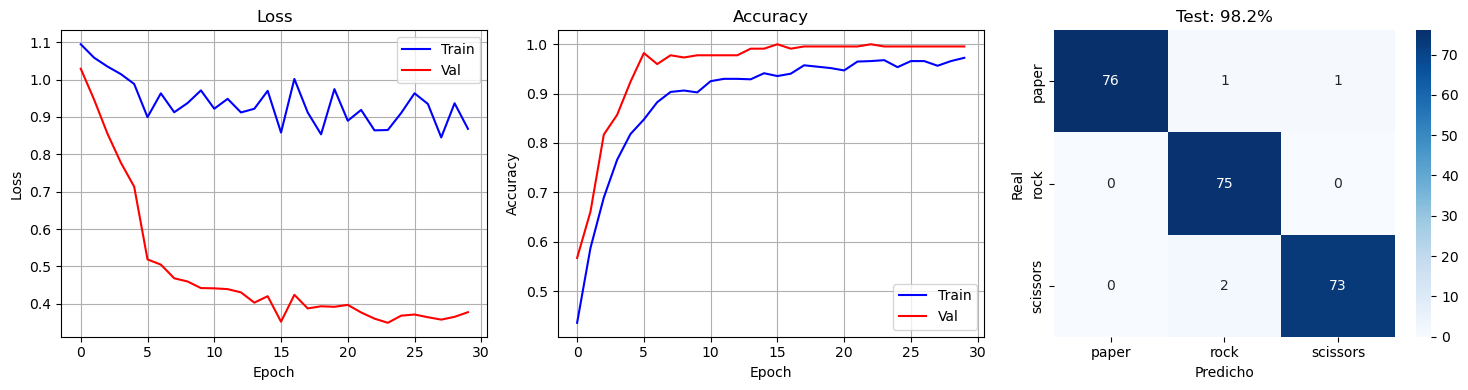


ENTRENAMIENTO COMPLETADO
  Mejor modelo: best_model_synchronized.pth
  Gráficas: results_synchronized.png
  Test Accuracy: 98.2%


In [19]:
# ============================================
# MAIN
# ============================================
if __name__ == "__main__":
    train()